# Loading the dataset

In [ ]:
import gdown
import zipfile
import os

def download_and_unzip_gdrive(gdrive_url, download_path, extract_path):
    # Get the file ID from the Google Drive URL
    file_id = gdrive_url.split("/")[-2]

    # Download the file
    gdown.download(f"https://drive.google.com/uc?id={file_id}", download_path, quiet=False)

    # Check if the downloaded file is a zip archive
    if download_path.endswith('.zip'):
        # Extract the contents of the zip file to the specified extract path
        with zipfile.ZipFile(download_path, 'r') as zip_ref:
            zip_ref.extractall(extract_path)
    else:
        print("The downloaded file is not a zip archive.")

# Usage example:
gdrive_url = "https://drive.google.com/file/d/1XVhkMMXKwigQrEPS1rKHbMAH2rKEQdTd/view?usp=drive_link"

In [ ]:
download_path = "/content/data/filename.zip"  # TODO: Change to the desired download path in your Colab environment Hint: filename.zip
extract_path = "/content/data/extracted/"  # TODO: Change to the desired extraction path

download_and_unzip_gdrive(gdrive_url, download_path, extract_path)


Downloading...
From: https://drive.google.com/uc?id=1XVhkMMXKwigQrEPS1rKHbMAH2rKEQdTd
To: /content/data/filename.zip
100%|██████████| 357M/357M [00:02<00:00, 129MB/s]


In [ ]:
# for data load
import os

# for reading and processing images
import imageio
from PIL import Image

import cv2
from tqdm.notebook import tqdm
# for visualizations
import matplotlib.pyplot as plt

import numpy as np # for using np arrays
from numpy import asarray

# for bulding and running deep learning model
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras.losses import binary_crossentropy
from sklearn.model_selection import train_test_split

## 1. UNDERSTAND THE DATA

In [ ]:
# Here , you will make a python function which will take paths of images,masks as arguments
# and return 2 ordered lists for quarter length of image filepaths and mask filepaths respectively.

# Hint : 1-  you may use os package for files listing.
# Hint : 2 - you may use sort function for ordering lists

import os

def quarter_length_file_lists(image_dir, mask_dir):
    # List image files and sort them
    image_files = os.listdir(image_dir)
    image_files.sort()

    # List mask files and sort them
    mask_files = os.listdir(mask_dir)
    mask_files.sort()

    # Calculate the quarter length
    quarter_length = min(len(image_files), len(mask_files)) // 4

    # Get the first quarter of file paths
    quarter_image_paths = [os.path.join(image_dir, filename) for filename in image_files[:quarter_length]]
    quarter_mask_paths = [os.path.join(mask_dir, filename) for filename in mask_files[:quarter_length]]

    return quarter_image_paths, quarter_mask_paths

(256, 256, 3)
(256, 256)


<ipython-input-5-8402069ca9e9>:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img_view  = imageio.imread(path1 +'/'+ 'Img_10.jpg')
<ipython-input-5-8402069ca9e9>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask_view = imageio.imread(path2 +'/'+ 'Img_10.jpg')


Text(0.5, 1.0, 'Masked Image Img_10.jpg')

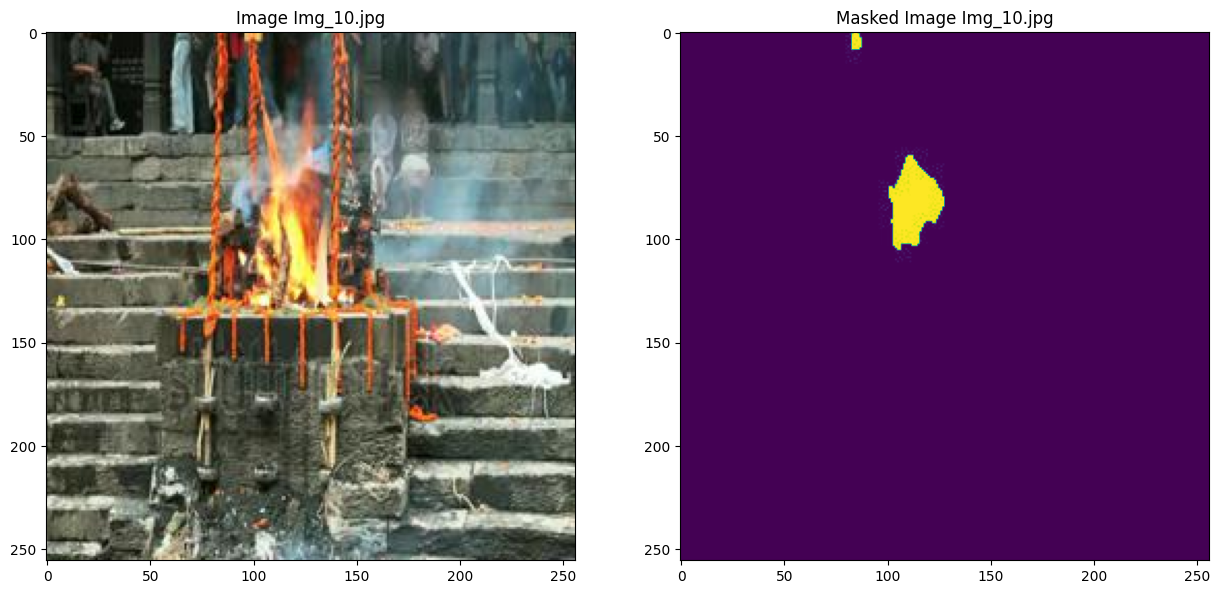

In [ ]:
path1 = '/content/data/extracted/Image/Fire/'   ## TODO
path2 = '/content/data/extracted/Segmentation_Mask/Fire'    ## TODO
img, mask = quarter_length_file_lists(path1, path2)  ### TODO: Call the above function here to load file paths for images and masks

# print(img, mask)
img_view  = imageio.imread(path1 +'/'+ 'Img_10.jpg')
mask_view = imageio.imread(path2 +'/'+ 'Img_10.jpg')

print(img_view.shape)
print(mask_view.shape)
fig, arr = plt.subplots(1, 2, figsize=(15, 15))
arr[0].imshow(img_view)
arr[0].set_title('Image ' + 'Img_10.jpg')
arr[1].imshow(mask_view)
arr[1].set_title('Masked Image '+ 'Img_10.jpg')

In [ ]:
def PreprocessData(img, mask, target_shape_img, target_shape_mask, path1, path2):
    """
    Processes the images and mask present in the shared list and path
    Returns a NumPy dataset with images as 3-D arrays of desired size
    Please note the masks in this dataset have only one channel
    """
    # Pull the relevant dimensions for image and mask
    m = len(img)                      # TODO: Assigned number of images to m variable here
    i_h,i_w,i_c = target_shape_img  # TODO:  pull height, width, and channels of image Hint: target_shape_img
    m_h,m_w,m_c = target_shape_mask # TODO:  pull height, width, and channels of mask

    # Define X and Y as number of images along with shape of one image
    X = np.zeros((m,i_h,i_w,i_c), dtype=np.float32)
    y = np.zeros((m,m_h,m_w,m_c), dtype=np.int32)

    # Resize images and masks
    for file in tqdm(img):
        # convert image into an array of desired shape (3 channels)
        index = img.index(file)
        path = os.path.join(path1, file)
        single_img = Image.open(path).convert('RGB')
        single_img = single_img.resize((i_h,i_w))
        single_img = np.reshape(single_img,(i_h,i_w,i_c))
        single_img = single_img/255.
        X[index] = single_img

        # convert mask into an array of desired shape (1 channel)

        single_mask_ind = mask[index]
        path = os.path.join(path2, single_mask_ind)
        single_mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        single_mask = cv2.resize(single_mask, dsize=(m_h, m_w), interpolation=cv2.INTER_NEAREST)
        single_mask = asarray(single_mask)
        single_mask = single_mask[..., tf.newaxis]
        single_mask = np.reshape(single_mask,(m_h,m_w,m_c))
        single_mask = single_mask/255
        single_mask = single_mask.astype(int)
        y[index] = single_mask
    return X, y

  0%|          | 0/6865 [00:00<?, ?it/s]

X Shape: (6865, 128, 128, 3)
Y shape: (6865, 128, 128, 1)
[0 1]


Text(0.5, 1.0, 'Processed Masked Image ')

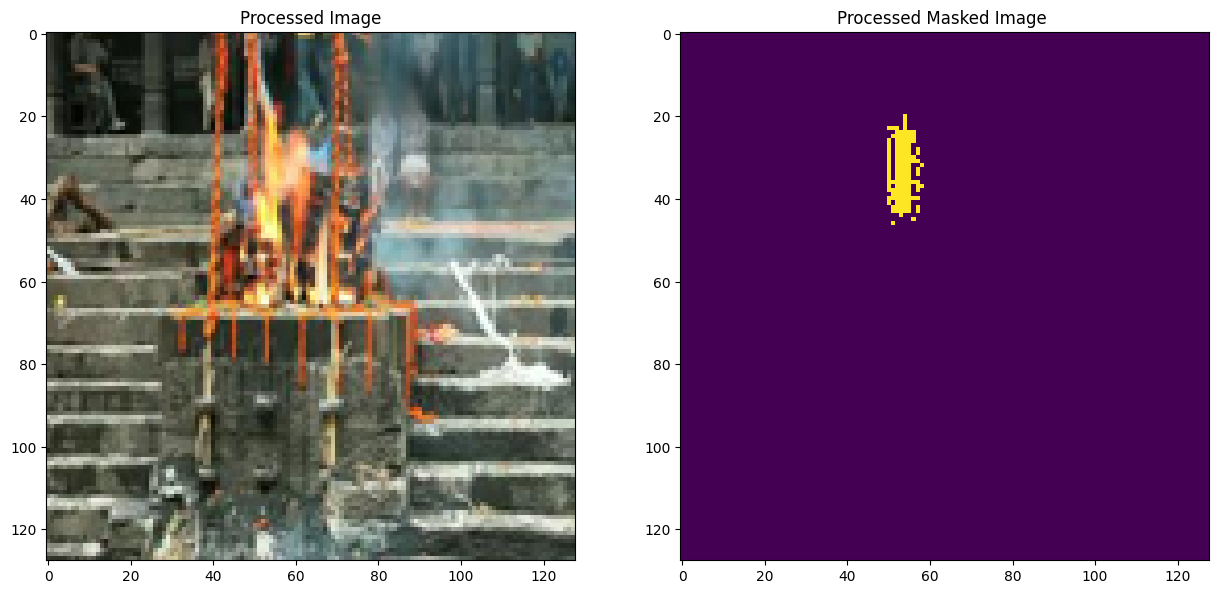

In [ ]:
# Define the desired shape
target_shape_img = [128, 128, 3]
target_shape_mask = [128, 128, 1]

# Process data using apt helper function

# X, y = PreprocessData(img, mask, target_shape_img, target_shape_mask, path1, path2)
X, y = PreprocessData(img, mask, target_shape_img, target_shape_mask, path1, path2)

# QC the shape of output and classes in output dataset
print("X Shape:", X.shape)
print("Y shape:", y.shape)
# There are 2 classes
print(np.unique(y))

# Visualize the output
image_index = 0
fig, arr = plt.subplots(1, 2, figsize=(15, 15))
arr[0].imshow(X[image_index])
arr[0].set_title('Processed Image')
arr[1].imshow(y[image_index,:,:,0])
arr[1].set_title('Processed Masked Image ')

## 2. UNET MODELING

In [ ]:
def EncoderMiniBlock(inputs, n_filters=32, dropout_prob=0.3, max_pooling=True):
    """
    This block uses multiple convolution layers, max pool, relu activation to create an architecture for learning.
    Dropout can be added for regularization to prevent overfitting.
    The block returns the activation values for next layer along with a skip connection which will be used in the decoder
    """
    # Add 2 Conv Layers with relu activation and HeNormal initialization using TensorFlow
    # Proper initialization prevents from the problem of exploding and vanishing gradients
    # 'Same' padding will pad the input to conv layer such that the output has the same height and width (hence, is not reduced in size)
    conv = Conv2D(n_filters,
                  kernel_size = 3,
                  activation = 'relu',
                  # TODO: apply kernel size 3,
                  # TODO, apply activation relu,
                  padding='same',
                  kernel_initializer='HeNormal')(inputs)
    conv = Conv2D(n_filters,
                  kernel_size = 3,
                  activation = 'relu',
                   # TODO: apply kernel size 3,   # Kernel size
                   # TODO, apply activation relu,
                  padding='same',
                  kernel_initializer = 'HeNormal'
                 # TODO: Apply HeNormal kernel initializer,
                  )(conv)

    # Batch Normalization will normalize the output of the last layer based on the batch's mean and standard deviation
    conv = BatchNormalization()(conv, training=False)

    # In case of overfitting, dropout will regularize the loss and gradient computation to shrink the influence of weights on output
    if dropout_prob > 0:
        conv = tf.keras.layers.Dropout(dropout_prob)(conv)

    # Pooling reduces the size of the image while keeping the number of channels same
    # Pooling has been kept as optional as the last encoder layer does not use pooling (hence, makes the encoder block flexible to use)
    # Below, Max pooling considers the maximum of the input slice for output computation and uses stride of 2 to traverse across input image
    if max_pooling:
        next_layer = tf.keras.layers.MaxPooling2D(pool_size = (2,2))(conv)
    else:
        next_layer = conv

    # skip connection (without max pooling) will be input to the decoder layer to prevent information loss during transpose convolutions
    skip_connection = conv

    return next_layer, skip_connection

In [ ]:
def DecoderMiniBlock(prev_layer_input, skip_layer_input, n_filters=32):
    """
    Decoder Block first uses transpose convolution to upscale the image to a bigger size and then,
    merges the result with skip layer results from encoder block
    Adding 2 convolutions with 'same' padding helps further increase the depth of the network for better predictions
    The function returns the decoded layer output
    """
    # Start with a transpose convolution layer to first increase the size of the image
    up = Conv2DTranspose(
                 n_filters,
                 (3,3),    # Kernel size
                 strides=(2,2),
                 padding='same')(prev_layer_input)

    # Merge the skip connection from previous block to prevent information loss
    merge = concatenate([up, skip_layer_input], axis=3)

    # Add 2 Conv Layers with relu activation and HeNormal initialization for further processing
    # The parameters for the function are similar to encoder
    conv = Conv2D(n_filters,
                 3,     # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='HeNormal')(merge)
    conv = Conv2D(n_filters,
                 3,   # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='HeNormal')(conv)
    return conv

In [ ]:
def UNetCompiled(input_size=(128, 128, 3), n_filters=32, n_classes=2):
    inputs = Input(input_size)

    # Encoder includes multiple convolutional mini blocks with different maxpooling, dropout and filter parameters
    # Observe that the filters are increasing as we go deeper into the network which will increasse the # channels of the image
    cblock1 = EncoderMiniBlock(inputs, n_filters,dropout_prob=0, max_pooling=True)
    cblock2 = EncoderMiniBlock(cblock1[0],n_filters*2,dropout_prob=0, max_pooling=True)
    cblock3 = EncoderMiniBlock(cblock2[0],n_filters*4,dropout_prob=0, max_pooling=True)
    cblock4 = EncoderMiniBlock(cblock3[0],n_filters*8,dropout_prob=0.3, max_pooling=True) #TODO: Similarly, create another encoder block with filters multiple of 8 and dropout changed to 0.3.
    cblock5 = EncoderMiniBlock(cblock4[0],n_filters*16,dropout_prob=0.3, max_pooling=False) #TODO: Similarly, create another encoder block with filters multiple of 16 and dropout is still 0.3

    # Decoder includes multiple mini blocks with decreasing number of filters
    # Observe the skip connections from the encoder are given as input to the decoder
    # Recall the 2nd output of encoder block was skip connection, hence cblockn[1] is used
    ublock6 = DecoderMiniBlock(cblock5[0], cblock4[1],  n_filters * 8)
    ublock7 = DecoderMiniBlock(ublock6, cblock3[1],  n_filters * 4)
    ublock8 = DecoderMiniBlock(ublock7, cblock2[1],  n_filters * 2)
    ublock9 = DecoderMiniBlock(ublock8, cblock1[1],  n_filters)

    # Complete the model with 1 3x3 convolution layer (Same as the prev Conv Layers)
    # Followed by a 1x1 Conv layer to get the image to the desired size.
    # Observe the number of channels will be equal to number of output classes
    conv9 = Conv2D(n_filters,
                3,
                activation='relu',
                padding='same',
                kernel_initializer='he_normal')(ublock9)

    conv10 = Conv2D(n_classes, 1, padding='same')(conv9)

    # Define the model
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [ ]:
# Use scikit-learn's function to split the dataset
# Here, I have used 20% data as test/valid set
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True) ###TODO:  Use train_test_split from sklearn to split with 80/20 ratio

# Call the helper function for defining the layers for the model, given the input image size
unet = UNetCompiled(input_size=(128,128,3), n_filters=32, n_classes=3)

# Check the summary to better interpret how the output dimensions change in each layer
unet.summary() # TODO: Print or output the architecture unet

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 32)         896       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 32)         9248      ['conv2d[0][0]']              
                                                                                                  
 batch_normalization (Batch  (None, 128, 128, 32)         128       ['conv2d_1[0][0]']            
 Normalization)                                                                               

In [ ]:
# EarlyStopping
from keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
patience=5,
restore_best_weights=True,
mode='min')

In [ ]:
# There are multiple optimizers, loss functions and metrics that can be used to compile multi-class segmentation models
# Ideally, try different options to get the best accuracy
unet.compile(optimizer=tf.keras.optimizers.Adam(lr=0.000001), # TODO Apply Adam Optimizer,
             loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), # TODO Apply loss for binary classification Hint: from_logits=True,
              metrics=['accuracy'])

# Run the model in a mini-batch fashion and compute the progress for each epoch
results = unet.fit(
    X_train, # TODO: Specicy X train set,
    y_train, # TODO: Specicy y train set,
    batch_size = 10, # TODO: Specicy batch size,
    epochs = 20, # TODO: Specicy epochs,
    validation_data=(X_valid, y_valid),
    callbacks=[early_stop])

Epoch 1/20
550/550 [==============================] - 66s 84ms/step - loss: 0.0379 - accuracy: 0.9885 - val_loss: 0.0205 - val_accuracy: 0.9917
Epoch 2/20
550/550 [==============================] - 46s 84ms/step - loss: 0.0197 - accuracy: 0.9918 - val_loss: 0.0188 - val_accuracy: 0.9920
Epoch 3/20
550/550 [==============================] - 46s 84ms/step - loss: 0.0177 - accuracy: 0.9924 - val_loss: 0.0170 - val_accuracy: 0.9927
Epoch 4/20
550/550 [==============================] - 44s 80ms/step - loss: 0.0164 - accuracy: 0.9928 - val_loss: 0.0157 - val_accuracy: 0.9931
Epoch 5/20
550/550 [==============================] - 44s 79ms/step - loss: 0.0156 - accuracy: 0.9930 - val_loss: 0.0158 - val_accuracy: 0.9930
Epoch 6/20
550/550 [==============================] - 46s 84ms/step - loss: 0.0150 - accuracy: 0.9932 - val_loss: 0.0154 - val_accuracy: 0.9932
Epoch 7/20
550/550 [==============================] - 46s 84ms/step - loss: 0.0147 - accuracy: 0.9934 - val_loss: 0.0165 - val_accuracy:

## 3. PREDICTIONS

In [ ]:
# predict masks
predictions = []
for img in tqdm(X_valid):
    img = img[np.newaxis, ...]
    pred_y = unet.predict(img)
    pred_mask = tf.argmax(pred_y[0], axis=-1)
    predictions.append(pred_mask)

In [ ]:
def rle_encoding(x):
    '''
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten()==1)[0] # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

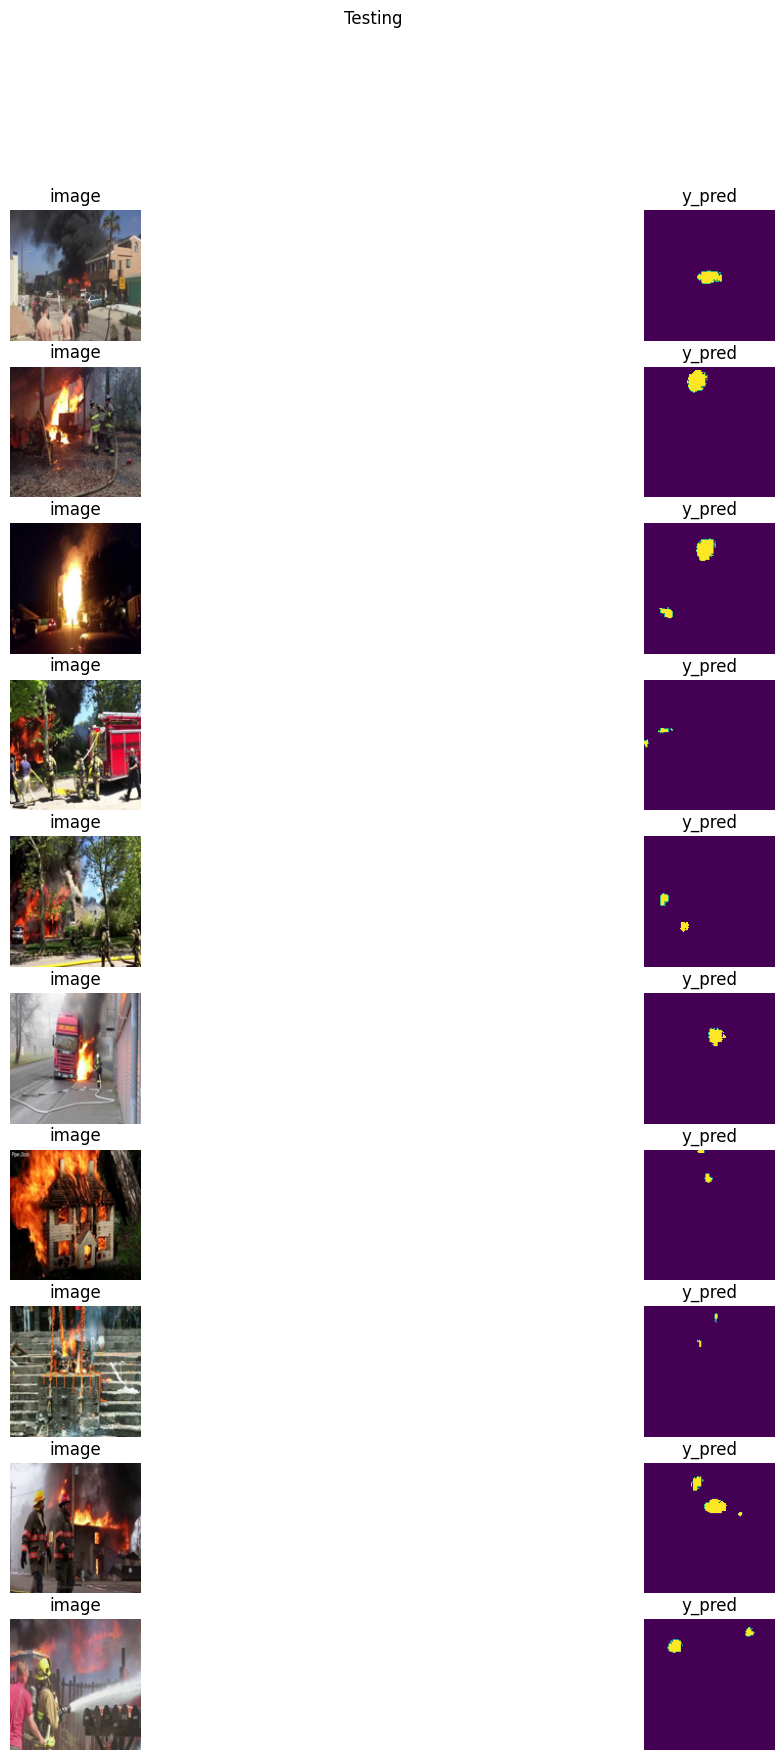

In [ ]:
# sample
n_imgs = 10
fig,axs = plt.subplots(10,2,figsize = (15,20))
fig.suptitle('Testing')
for i in range(n_imgs):
    axs[i,0].set_title('image')
    axs[i,0].imshow(X_valid[i])
    axs[i,0].axis('off')

    axs[i,1].set_title('y_pred')
    axs[i,1].imshow(predictions[i])
    axs[i,1].axis('off')